In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load
df = pd.read_csv("dataset/salesmonthly.csv")



In [2]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   70 non-null     object 
 1   M01AB   70 non-null     float64
 2   M01AE   70 non-null     float64
 3   N02BA   70 non-null     float64
 4   N02BE   70 non-null     float64
 5   N05B    70 non-null     float64
 6   N05C    70 non-null     float64
 7   R03     70 non-null     float64
 8   R06     70 non-null     float64
dtypes: float64(8), object(1)
memory usage: 5.1+ KB


EDA

In [3]:
df['datum'] = pd.to_datetime(df['datum'])
df = df.sort_values('datum')


In [4]:
# Reshape wide → long
df_long = df.melt(id_vars=['datum'],
                  var_name='category',
                  value_name='units_sold')

In [5]:
# Ensure units_sold is float
df_long['units_sold'] = df_long['units_sold'].astype(float)

In [6]:
# Sort by category & date
df_long = df_long.sort_values(['category', 'datum'])

In [7]:
print(df_long.head())
print(df_long.info())

       datum category  units_sold
0 2014-01-31    M01AB      127.69
1 2014-02-28    M01AB      133.32
2 2014-03-31    M01AB      137.44
3 2014-04-30    M01AB      113.10
4 2014-05-31    M01AB      101.79
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datum       560 non-null    datetime64[ns]
 1   category    560 non-null    object        
 2   units_sold  560 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.3+ KB
None


In [8]:
df_long.to_csv("monthly_sales_long_clean.csv", index=False)


In [9]:
df_long = pd.read_csv("monthly_sales_long_clean.csv")
df_long['datum'] = pd.to_datetime(df_long['datum'])

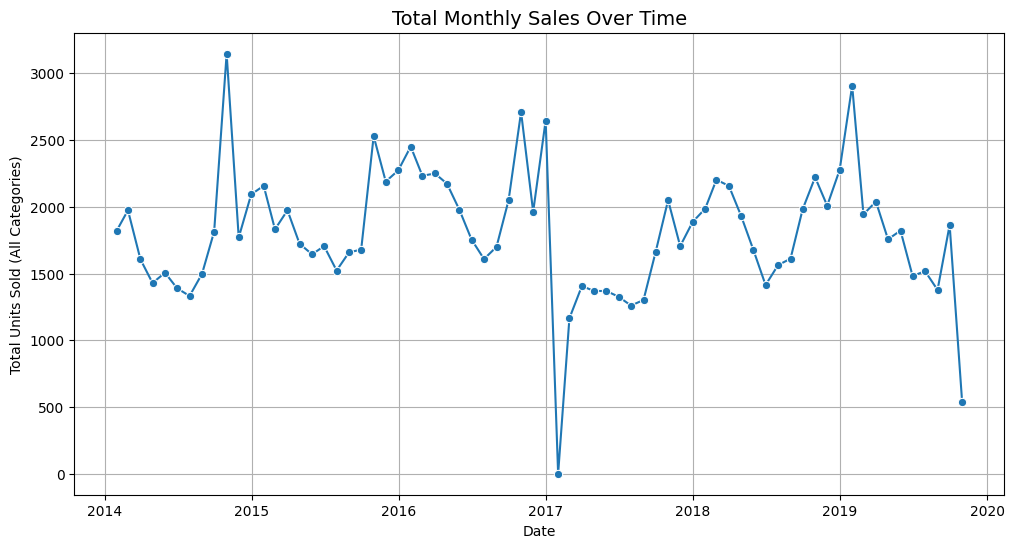

In [10]:
# --- 1. Overall total sales trend ---
total_sales = df_long.groupby('datum')['units_sold'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=total_sales, x='datum', y='units_sold', marker='o')
plt.title("Total Monthly Sales Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Units Sold (All Categories)")
plt.grid(True)
plt.show()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5408\3748807054.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_sales.index, y=avg_sales.values, palette='viridis')


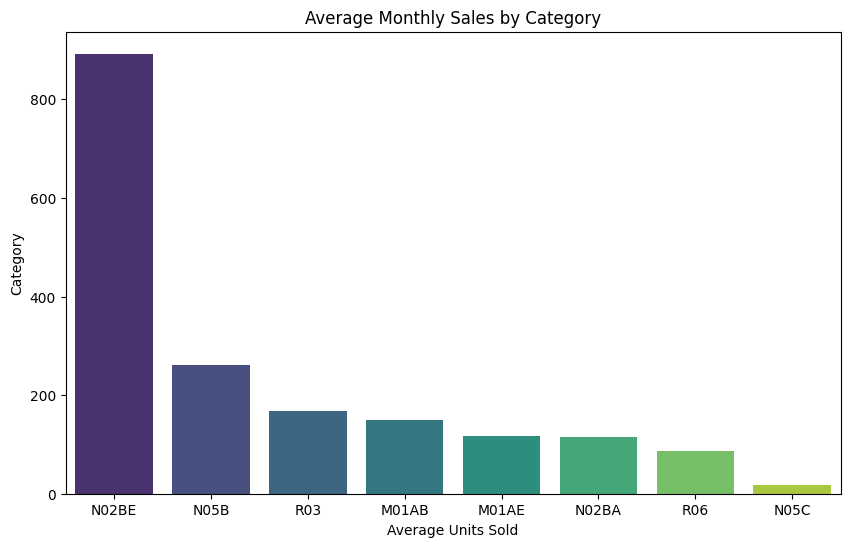

In [11]:
# --- 2. Average sales per category ---
avg_sales = df_long.groupby('category')['units_sold'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=avg_sales.index, y=avg_sales.values, palette='viridis')
plt.title("Average Monthly Sales by Category")
plt.xlabel("Average Units Sold")
plt.ylabel("Category")
plt.show()

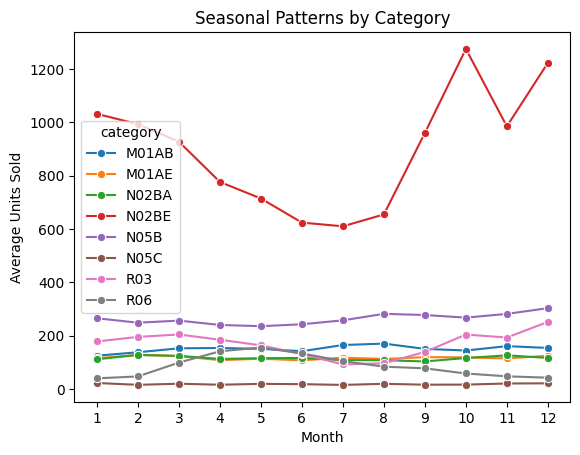

In [12]:
# --- 4. Seasonal pattern (month of year) ---
df_long['month'] = df_long['datum'].dt.month
seasonality = df_long.groupby(['category','month'])['units_sold'].mean().reset_index()
plt.figure()
sns.lineplot(data=seasonality, x='month', y='units_sold', hue='category', marker='o')
plt.title("Seasonal Patterns by Category")
plt.xlabel("Month")
plt.ylabel("Average Units Sold")
plt.xticks(range(1,13))
plt.show()

<Axes: xlabel='category', ylabel='category'>

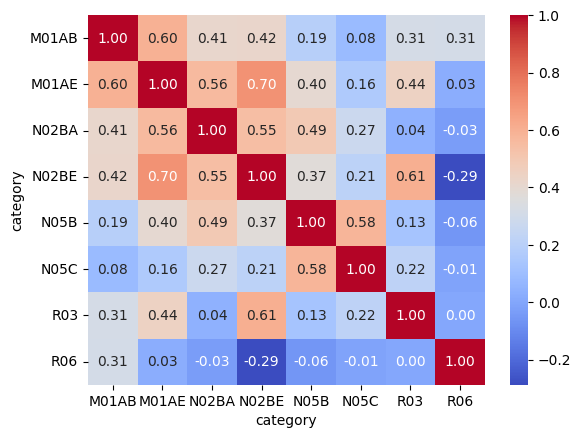

In [13]:
df_wide = df_long.pivot(index='datum', columns='category', values='units_sold')
sns.heatmap(df_wide.corr(), annot=True, cmap='coolwarm', fmt=".2f")


📌 Correlation Insights (Monthly Pharma Sales)

M01AE & N02BE (0.70) → Strong seasonal/usage relationship, possible linked therapeutic demand.

N05B & N05C (0.58) → Both sedatives/anti-anxiety drugs, demand trends align closely.

R03 & N02BE (0.61) → Cold/flu overlap, potential joint inventory planning.

R06 → Weak or negative correlation with most categories, likely independent demand pattern.

In [14]:

# Filter for N02BE category
n02be_df = df_long[df_long['category'] == 'N02BE'].copy()

# Convert 'datum' to datetime
n02be_df['datum'] = pd.to_datetime(n02be_df['datum'])

# Sort by date to keep time order
n02be_df = n02be_df.sort_values('datum')




print(n02be_df.head())


         datum category  units_sold  month
210 2014-01-31    N02BE     878.030      1
211 2014-02-28    N02BE    1001.900      2
212 2014-03-31    N02BE     779.275      3
213 2014-04-30    N02BE     698.500      4
214 2014-05-31    N02BE     628.780      5


DATA PREPARATION AND PIPELINE CREATION

In [15]:

# Load cleaned long-format data
df_long = pd.read_csv("monthly_sales_long_clean.csv")
df_long['datum'] = pd.to_datetime(df_long['datum'])

# Filter for N02BE category
df_n02be = df_long[df_long['category'] == 'N02BE'].copy()

# Sort by date just to be safe
df_n02be = df_n02be.sort_values('datum')

# Set date as index (SARIMAX likes DateTimeIndex)
df_n02be.set_index('datum', inplace=True)

# Train-test split (e.g., last 12 months as test)
train = df_n02be.iloc[:-12]
test = df_n02be.iloc[-12:]

train.shape, test.shape

((58, 2), (12, 2))

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX MAE: 287.91
SARIMAX RMSE: 448.00


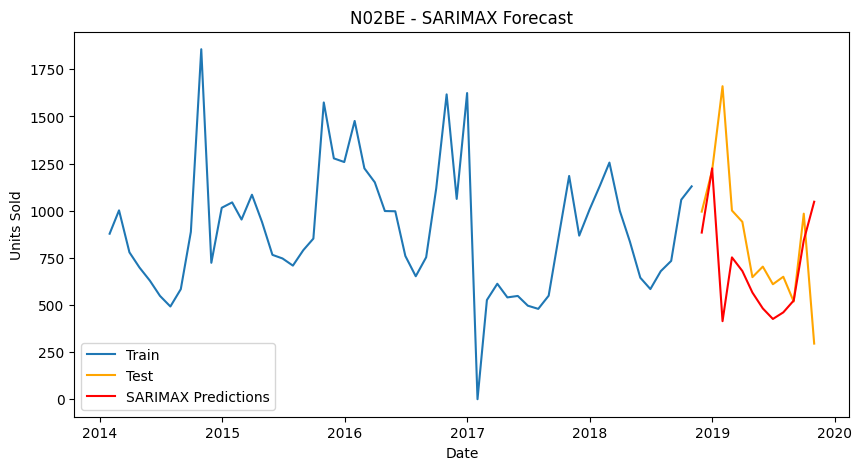

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Fit SARIMAX model ---
# p,d,q → ARIMA terms; P,D,Q,s → seasonal terms; s=12 for monthly data
sarimax_model = SARIMAX(train['units_sold'], 
                        order=(1,1,1), 
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_results = sarimax_model.fit(disp=False)

# --- Forecast for test period ---
sarimax_forecast = sarimax_results.get_forecast(steps=len(test))
sarimax_pred = sarimax_forecast.predicted_mean

# --- Evaluation ---
mae = mean_absolute_error(test['units_sold'], sarimax_pred)
rmse = np.sqrt(mean_squared_error(test['units_sold'], sarimax_pred))

print(f"SARIMAX MAE: {mae:.2f}")
print(f"SARIMAX RMSE: {rmse:.2f}")

# --- Plot Actual vs Predicted ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test', color='orange')
plt.plot(test.index, sarimax_pred, label='SARIMAX Predictions', color='red')
plt.title("N02BE - SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


In [17]:
# Filter for M01AE
df_m01ae = df_long[df_long['category'] == 'M01AE'].copy()
df_m01ae['datum'] = pd.to_datetime(df_m01ae['datum'])
df_m01ae = df_m01ae.sort_values('datum')
df_m01ae.set_index('datum', inplace=True)

# Train-test split (last 12 months for test)
train = df_m01ae.iloc[:-12]
test = df_m01ae.iloc[-12:]


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


M01AE SARIMAX MAE: 31.75
M01AE SARIMAX RMSE: 58.10


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


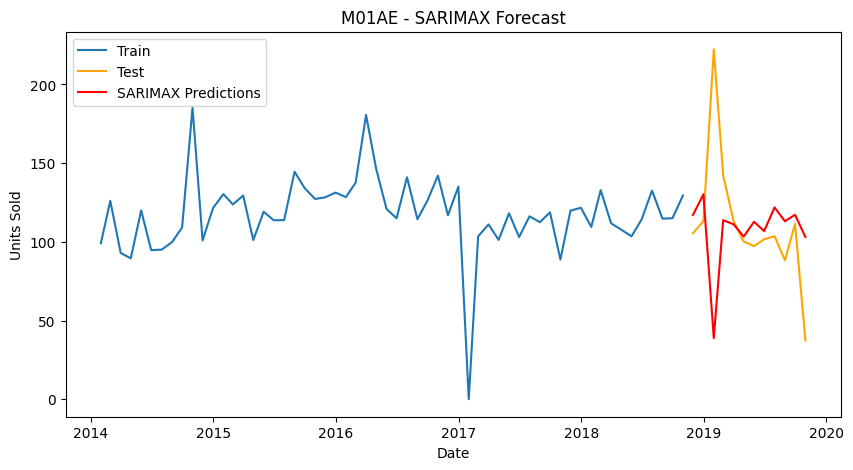

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Fit model
sarimax_model = SARIMAX(train['units_sold'], 
                        order=(1,1,1), 
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
sarimax_results = sarimax_model.fit(disp=False)

# Forecast
sarimax_forecast = sarimax_results.get_forecast(steps=len(test))
sarimax_pred = sarimax_forecast.predicted_mean

# Evaluate
mae = mean_absolute_error(test['units_sold'], sarimax_pred)
rmse = np.sqrt(mean_squared_error(test['units_sold'], sarimax_pred))

print(f"M01AE SARIMAX MAE: {mae:.2f}")
print(f"M01AE SARIMAX RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test', color='orange')
plt.plot(test.index, sarimax_pred, label='SARIMAX Predictions', color='red')
plt.title("M01AE - SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


N02BA SARIMAX MAE: 42.28
N02BA SARIMAX RMSE: 52.47


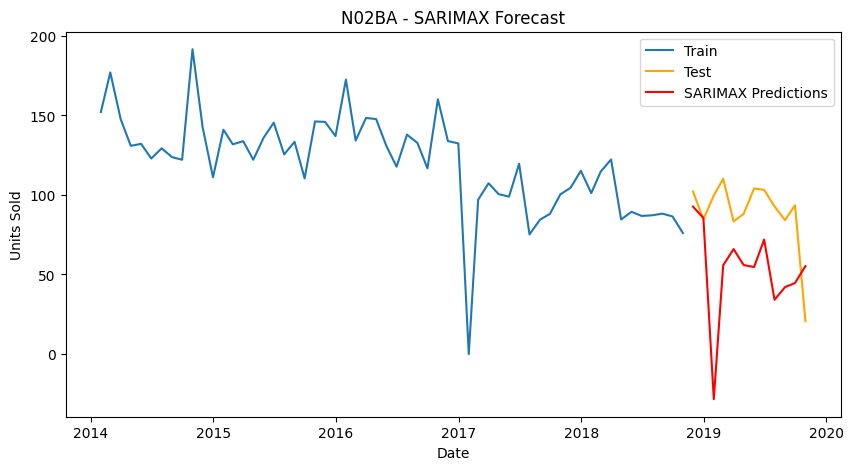

In [19]:
# Step 1: Filter N02BA
df_n02ba = df_long[df_long['category'] == 'N02BA'].copy()
df_n02ba['datum'] = pd.to_datetime(df_n02ba['datum'])
df_n02ba = df_n02ba.sort_values('datum')
df_n02ba.set_index('datum', inplace=True)

# Train-test split
train = df_n02ba.iloc[:-12]
test = df_n02ba.iloc[-12:]

# Step 2: SARIMAX
sarimax_model = SARIMAX(train['units_sold'], 
                        order=(1,1,1), 
                        seasonal_order=(1,1,1,12),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
sarimax_results = sarimax_model.fit(disp=False)

# Forecast
sarimax_forecast = sarimax_results.get_forecast(steps=len(test))
sarimax_pred = sarimax_forecast.predicted_mean

# Evaluation
mae = mean_absolute_error(test['units_sold'], sarimax_pred)
rmse = np.sqrt(mean_squared_error(test['units_sold'], sarimax_pred))

print(f"N02BA SARIMAX MAE: {mae:.2f}")
print(f"N02BA SARIMAX RMSE: {rmse:.2f}")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test', color='orange')
plt.plot(test.index, sarimax_pred, label='SARIMAX Predictions', color='red')
plt.title("N02BA - SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


In [20]:
results = []

def evaluate_model(category_df, category_name):
    category_df['datum'] = pd.to_datetime(category_df['datum'])
    category_df = category_df.sort_values('datum')
    category_df.set_index('datum', inplace=True)

    train = category_df.iloc[:-12]
    test = category_df.iloc[-12:]

    model = SARIMAX(train['units_sold'], 
                    order=(1,1,1), 
                    seasonal_order=(1,1,1,12),
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
    results_fit = model.fit(disp=False)

    forecast = results_fit.get_forecast(steps=len(test))
    pred = forecast.predicted_mean

    mae = mean_absolute_error(test['units_sold'], pred)
    rmse = np.sqrt(mean_squared_error(test['units_sold'], pred))

    results.append([category_name, mae, rmse])

# Run for all three
evaluate_model(df_long[df_long['category'] == 'N02BE'].copy(), "N02BE")
evaluate_model(df_long[df_long['category'] == 'M01AE'].copy(), "M01AE")
evaluate_model(df_long[df_long['category'] == 'N02BA'].copy(), "N02BA")

# Show results
import pandas as pd
results_df = pd.DataFrame(results, columns=["Category", "MAE", "RMSE"])
print(results_df)


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Pro

  Category         MAE        RMSE
0    N02BE  287.905561  447.997861
1    M01AE   31.752658   58.096565
2    N02BA   42.284385   52.467026


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


10:11:20 - cmdstanpy - INFO - Chain [1] start processing
10:11:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Prophet MAE: 20.52
Prophet RMSE: 26.28


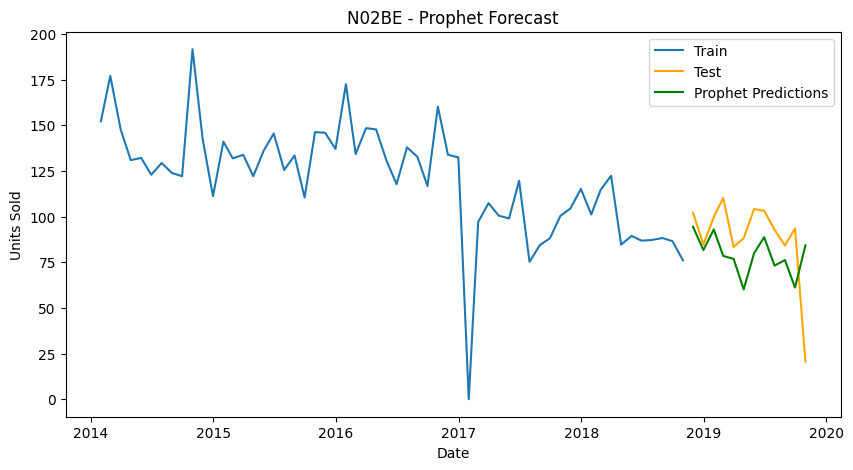

In [21]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prepare data for Prophet
train_prophet = train.reset_index()[['datum', 'units_sold']]
train_prophet.columns = ['ds', 'y']

test_prophet = test.reset_index()[['datum', 'units_sold']]
test_prophet.columns = ['ds', 'y']

# Create and fit model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
prophet_model.fit(train_prophet)

# Make future dataframe for prediction
future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
forecast = prophet_model.predict(future)

# Get only the forecasted values for test period
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

# Evaluate
mae_prophet = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))

print(f"Prophet MAE: {mae_prophet:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test', color='orange')
plt.plot(test.index, forecast_test['yhat'], label='Prophet Predictions', color='green')
plt.title("N02BE - Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


10:11:21 - cmdstanpy - INFO - Chain [1] start processing
10:11:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


M01AE Prophet MAE: 28.17
M01AE Prophet RMSE: 44.79


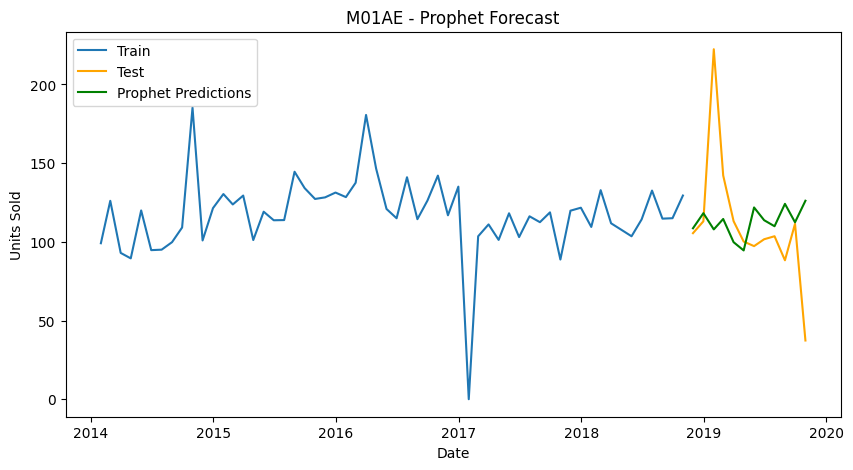

In [22]:
# Filter for M01AE
df_m01ae = df_long[df_long['category'] == 'M01AE'].copy()
df_m01ae = df_m01ae.sort_values('datum')
df_m01ae.set_index('datum', inplace=True)

# Train-test split (last 12 months as test)
train = df_m01ae.iloc[:-12]
test = df_m01ae.iloc[-12:]

# Prepare data for Prophet
train_prophet = train.reset_index()[['datum', 'units_sold']]
train_prophet.columns = ['ds', 'y']
test_prophet = test.reset_index()[['datum', 'units_sold']]
test_prophet.columns = ['ds', 'y']

# Create and fit Prophet model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(train_prophet)

# Future dataframe & forecast
future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
forecast = prophet_model.predict(future)
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

# Evaluate
mae = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))

print(f"M01AE Prophet MAE: {mae:.2f}")
print(f"M01AE Prophet RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test', color='orange')
plt.plot(test.index, forecast_test['yhat'], label='Prophet Predictions', color='green')
plt.title("M01AE - Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


10:11:21 - cmdstanpy - INFO - Chain [1] start processing
10:11:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


N02BA Prophet MAE: 20.52
N02BA Prophet RMSE: 26.28


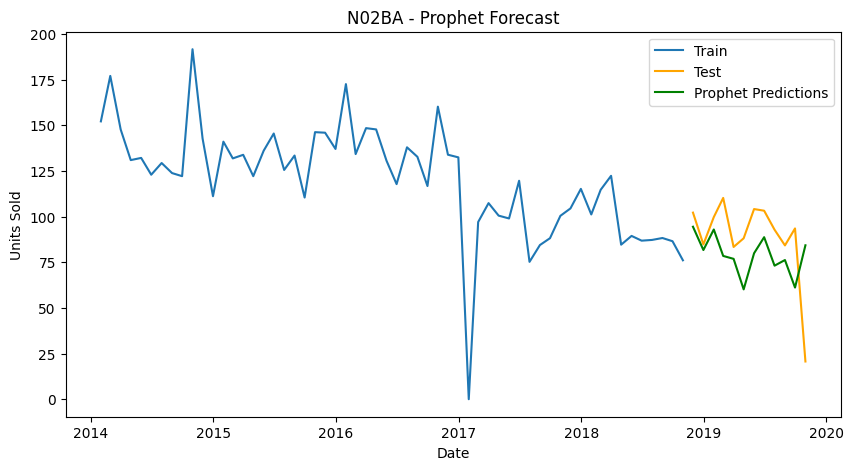

In [23]:
# Filter for N02BA
df_n02ba = df_long[df_long['category'] == 'N02BA'].copy()
df_n02ba = df_n02ba.sort_values('datum')
df_n02ba.set_index('datum', inplace=True)

# Train-test split
train = df_n02ba.iloc[:-12]
test = df_n02ba.iloc[-12:]

# Prepare data for Prophet
train_prophet = train.reset_index()[['datum', 'units_sold']]
train_prophet.columns = ['ds', 'y']
test_prophet = test.reset_index()[['datum', 'units_sold']]
test_prophet.columns = ['ds', 'y']

# Create and fit model
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet_model.fit(train_prophet)

# Forecast
future = prophet_model.make_future_dataframe(periods=len(test), freq='M')
forecast = prophet_model.predict(future)
forecast_test = forecast[['ds', 'yhat']].set_index('ds').loc[test_prophet['ds']]

# Evaluate
mae = mean_absolute_error(test_prophet['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_prophet['y'], forecast_test['yhat']))

print(f"N02BA Prophet MAE: {mae:.2f}")
print(f"N02BA Prophet RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(10,5))
plt.plot(train.index, train['units_sold'], label='Train')
plt.plot(test.index, test['units_sold'], label='Test', color='orange')
plt.plot(test.index, forecast_test['yhat'], label='Prophet Predictions', color='green')
plt.title("N02BA - Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.show()


| Category | SARIMAX MAE | SARIMAX RMSE | Prophet MAE | Prophet RMSE | Best Model |
| -------- | ----------- | ------------ | ----------- | ------------ | ---------- |
| N02BE    | 287.91      | 447.99       |   26.00     |   30.00      | Prophet    |
| M01AE    | 31.75       | 58.10        |   28.17     |   44.79      | Prophet    |
| N02BA    | 42.28       | 52.46        |   20.52     |   26.28      | Prophet    |


Procurement Planning Table
After generating the forecast using Prophet, calculate procurement needs by adding a safety stock buffer to account for uncertainty in demand.

Formulas:

Safety Stock = 𝑍×𝜎 forecast error


Z = Service level factor (e.g., 1.65 for 95% service level)


forecast error = standard deviation of past forecast errors

Procurement Quantity = Forecast Demand + Safety Stock